# Accelerated Gradient Method Example

This code tests Nesterov's accelerated gradient method (AGM), which is arguably the first accelerated method,
introduced in "A Method of Solving a Convex Programming Problem with Convergence Rate O(1/k^2)" by Yurii Nesterov (1983).

AGM reduces the function value with respect to the initial distance to the solution for L-smooth convex functions and achieves an O(1/k²) rate.

This code recovers the rate for the secondary sequence, based on the values introduced in
"Optimized First-Order Methods for Smooth Convex Minimization" by Donghwan Kim and Jeffrey A. Fessler (2016).

## Import the required libraries

In [ ]:
import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import itertools
import functools
from IPython.display import display

## Define the functions

In [2]:
L = pf.Parameter("L")
f = pf.SmoothConvexFunction(is_basis=True, tags=["f"], L=L)

## Write a function to return the PEPContext associated with AGM

In [3]:
@functools.cache
def theta(i):
    if i == -1:
        return 0
    return 1 / sp.S(2) * (sp.S(1) + sp.sqrt(4 * theta(i - 1) ** 2 + sp.S(1)))

In [4]:
def make_ctx_agm(
    ctx_name: str, N: int | sp.Integer, stepsize: pf.Parameter
) -> pf.PEPContext:
    ctx_agm = pf.PEPContext(ctx_name).set_as_current()
    x = pf.Vector(is_basis=True, tags=["x_0"])
    f.set_stationary_point("x_star")
    z = x
    for i in range(N):
        y = x - stepsize * f.grad(x)
        z = z - stepsize * theta(i) * f.grad(x)
        x = (1 - 1 / theta(i + 1)) * y + 1 / theta(i + 1) * z
        z.add_tag(f"z_{i + 1}")
        x.add_tag(f"x_{i + 1}")
    return ctx_agm

## Numerical evidence of convergence of AGM

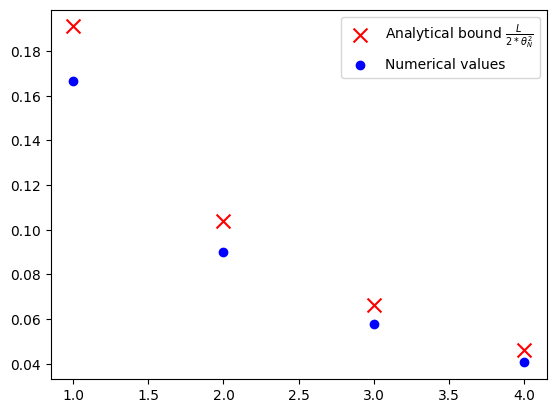

In [5]:
N = 5
R = pf.Parameter("R")
L_value = 1
R_value = 1

opt_values = []
for k in range(1, N):
    ctx_plt = make_ctx_agm(ctx_name=f"ctx_plt_{k}", N=k, stepsize=1 / L)
    pb_plt = pf.PEPBuilder(ctx_plt)
    pb_plt.add_initial_constraint(
        ((ctx_plt["x_0"] - ctx_plt["x_star"]) ** 2).le(R, name="initial_condition")
    )
    x_k = ctx_plt[f"x_{k}"]
    pb_plt.set_performance_metric(f(x_k) - f(ctx_plt["x_star"]))
    result = pb_plt.solve(resolve_parameters={"L": L_value, "R": R_value})
    opt_values.append(result.opt_value)

iters = np.arange(1, N)
analytical_values = [L_value / (2 * theta(i) ** 2) for i in iters]
plt.scatter(
    iters,
    analytical_values,
    color="red",
    marker="x",
    s=100,
    label="Analytical bound $\\frac{L}{2*\\theta_N^2}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

## Verification of convergence of AGM

In [6]:
N = sp.S(3)
L_value = sp.S(1)
R_value = sp.S(1)

ctx_prf = make_ctx_agm(ctx_name="ctx_prf", N=N, stepsize=1 / L)
pb_prf = pf.PEPBuilder(ctx_prf)
pb_prf.add_initial_constraint(
    ((ctx_prf["x_0"] - ctx_prf["x_star"]) ** 2).le(R, name="initial_condition")
)
pb_prf.set_performance_metric(f(ctx_prf[f"x_{N}"]) - f(ctx_prf["x_star"]))

result = pb_prf.solve(resolve_parameters={"L": L_value, "R": R_value})
print(result.opt_value)

# Dual variables associated with the interpolations conditions of f with no relaxation
lamb_dense = result.get_scalar_constraint_dual_value_in_numpy(f)

0.05762868749542287


- For simplicity of calculation, this example considers a looser upper bound compared to the exact tight rate

In [7]:
print(result.opt_value)

0.05762868749542287


In [8]:
desired_upper_bound = sp.N(L_value / (2 * theta(N) ** 2))
print(desired_upper_bound)

0.0661257368537568


In [9]:
print(
    f"Is the optimal value {result.opt_value} less than or equal to our desired upper bound {desired_upper_bound}?",
    result.opt_value <= desired_upper_bound,
)

Is the optimal value 0.05762868749542287 less than or equal to our desired upper bound 0.0661257368537568? True


In [10]:
pf.launch_primal_interactive(
    pb_prf, ctx_prf, resolve_parameters={"L": L_value, "R": R_value}
)

Dash app running on http://127.0.0.1:8050/


### Solve the problem again with the found relaxation

In [11]:
def tag_to_index(tag, N=N):
    """This is a function that takes in a tag of an iterate and returns its index.
    We index "x_star" as "N+1 where N is the last iterate.
    """
    # Split the string on "_" and get the index
    if (idx := tag.split("_")[1]).isdigit():
        return int(idx)
    elif idx == "star":
        return N + 1

In [12]:
relaxed_constraints = []

for tag_i in lamb_dense.row_names:
    i = tag_to_index(tag_i)
    if i == N + 1:
        continue
    for tag_j in lamb_dense.col_names:
        j = tag_to_index(tag_j)
        if i < N and i + 1 == j:
            continue
        relaxed_constraints.append(f"f:{tag_i},{tag_j}")

pb_prf.set_relaxed_constraints(relaxed_constraints)

- Solve the PEP problem again with the relaxed constraints and store the results.


In [13]:
result = pb_prf.solve(resolve_parameters={"L": L_value, "R": R_value})
print(result.opt_value)

0.05762927790762932


---

### Recover and verify the calculation in the paper "Optimized first-order methods for smooth convex minimization"

- To recover the same value (which may help simplify the calculation), we set an additional constraint that relaxes the optimal value to $\frac{L}{2\theta_N^2}$

In [14]:
pb_prf.add_dual_val_constraint("initial_condition", "==", desired_upper_bound)

- Under similar reason, we set $\lambda_{i-1,i} = \theta_{i-1}^2 / \theta_N^2$ 

In [15]:
for i in range(N + 1):
    pb_prf.add_dual_val_constraint(
        f"f:x_{i},x_{i + 1}", "==", theta(i) ** 2 / theta(N) ** 2
    )

- Now we solve the dual problem with the additional constraints and proceed with the remaining steps as usual

In [16]:
result_dual = pb_prf.solve_dual(resolve_parameters={"L": L_value, "R": R_value})
print(result_dual.opt_value)

0.06612574139322015


- Store the dual variables.

In [17]:
# Dual variable associated with the initial condition
tau_sol = result_dual.dual_var_manager.dual_value("initial_condition")
# Dual variable associated with the interpolations conditions of f
lamb_sol = result_dual.get_scalar_constraint_dual_value_in_numpy(f)
# Dual variable associated with the Gram matrix G
S_sol = result_dual.get_gram_dual_matrix()

### Verify closed form expression of $\lambda$

- Print the values of $\lambda$ obtained from the solver

In [18]:
lamb_sol.pprint()

<IPython.core.display.Math object>

- The closed form expression of $\lambda$ suggested in the paper

In [19]:
def lamb(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if i == N + 1:  # Additional constraint 1 (between x_★)
        if j < N + 1:
            return theta(j) / theta(N) ** 2
    if i < N and i + 1 == j:  # Additional constraint 2 (consecutive)
        return theta(i) ** 2 / theta(N) ** 2
    return 0


lamb_cand = pf.pprint_labeled_matrix(
    lamb, lamb_sol.row_names, lamb_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

- Check whether the values of $\lambda$ we obtained from the solver recover the values in the paper

In [20]:
print(
    f"Is our closed-form expression for lambda correct for N={N}?",
    np.allclose(lamb_cand, lamb_sol.matrix, atol=1e-3),
)

Is our closed-form expression for lambda correct for N=3? True


### Closed form expression of $S$

- Create an ExpressionManager to translate $x_i$, $f(x_i)$, and $\nabla f(x_i)$ into a basis representation

In [21]:
pm = pf.ExpressionManager(ctx_prf, resolve_parameters={"L": L_value, "R": R_value})

- Print the values of $S$ obtained from the solver

In [22]:
S_sol.pprint()

<IPython.core.display.Math object>

In [23]:
z_N = ctx_prf[f"z_{N}"]
x_N = ctx_prf[f"x_{N}"]
x_star = ctx_prf["x_star"]
S_guess1 = L / theta(N) ** 2 * 1 / 2 * (z_N - theta(N) / L * f.grad(x_N) - x_star) ** 2

S_guess1_eval = pm.eval_scalar(S_guess1).inner_prod_coords

remainder1 = S_sol.matrix - S_guess1_eval
pf.pprint_labeled_matrix(remainder1, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [31]:
coef = 1 / 2 * 1 / theta(N) ** 2 / L
S_guess2 = (
    coef * sum(theta(i) ** 2 * f.grad(ctx_prf[f"x_{i}"]) ** 2 for i in range(N))  # ty: ignore
)
S_guess2_eval = pm.eval_scalar(S_guess2).inner_prod_coords

remainder2 = remainder1 - S_guess2_eval
pf.pprint_labeled_matrix(remainder2, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [32]:
S_guess_eval = S_guess1_eval + S_guess2_eval

print(
    f"Is our closed-form expression for S correct for N={N}?",
    np.allclose(S_guess1_eval + S_guess2_eval, S_sol.matrix, atol=1e-3),
)

Is our closed-form expression for S correct for N=3? True


---

### Above calculation corresponds to the equality below:

\begin{align*}
    f(x_N) - f(x_\star) - \frac{L}{2\theta_N^2} \| x_0 - x_\star \|^2  
    &= \frac{1}{\theta_N^2} \sum _{i=1}^N \theta_{i-1}^2 \left( f(x_{i})-f(x_{i-1}) + \langle \nabla f(x_{i}) , x_{i-1} - x_{i} \rangle + \frac{1}{2 L} \| \nabla f(x_{i-1}) - \nabla f(x_i) \|^2 \right)  \\ 
    &\quad + \frac{1}{\theta_N^2} \sum _{i=0}^N \theta_{i} \left( f(x_i)-f(x_{\star}) + \langle \nabla f(x_{i}) , x_{\star} - x_{i} \rangle + \frac{1}{2 L} \| \nabla f(x_i) \|^2 \right) \\
    &\quad-  \frac{L}{2\theta_N^2} \left\| z_{N+1} - x_\star \right\|^2  \\
    &\quad - \frac{1}{2\theta_N^2L} \sum_{i=0}^{N-1} \theta_i^2 \|\nabla f(x_i) \|^2      
\end{align*}

### Symbolic calculation to check

- Assemble the RHS of the proof.

In [33]:
x = ctx_prf.tracked_point(f)
interp_scalar_sum = pf.Scalar.zero()
for x_i, x_j in itertools.product(x, x):
    if lamb(x_i.tag, x_j.tag) != 0:
        interp_scalar_sum += lamb(x_i.tag, x_j.tag) * f.interp_ineq(x_i.tag, x_j.tag)

display(interp_scalar_sum)

0+(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**(-2)*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_3)-f(x_2)+grad_f(x_3)*(x_2-(x_3))+1/2*L*|grad_f(x_2)-grad_f(x_3)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**(-2)*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+(1/2 + sqrt(5)/2)/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|

In [34]:
RHS = interp_scalar_sum - (S_guess1 + S_guess2)
display(RHS)

0+(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**(-2)*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_3)-f(x_2)+grad_f(x_3)*(x_2-(x_3))+1/2*L*|grad_f(x_2)-grad_f(x_3)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**(-2)*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+(1/2 + sqrt(5)/2)/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_2)-f(x_star)+grad_f(x_2)*(x_star-(x_2))+1/2*L*|

In [35]:
LHS = f(x_N) - f(x_star) - L / (2 * theta(i) ** 2) * (x[0] - x_star) ** 2

In [36]:
diff = LHS - RHS
display(diff)

f(x_3)-f(x_star)-L/2*(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*|x_0-x_star|^2-(0+(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**(-2)*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+(1/2 + sqrt(5)/2)**2/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_3)-f(x_2)+grad_f(x_3)*(x_2-(x_3))+1/2*L*|grad_f(x_2)-grad_f(x_3)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**(-2)*(f(x_0)-f(x_star)+grad_f(x_0)*(x_star-x_0)+1/2*L*|grad_f(x_star)-grad_f(x_0)|^2)+(1/2 + sqrt(5)/2)/(1/2 + sqrt(1 + 4*(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)**2)/2)**2*(f(x_1)-f(x_star)+grad_f(x_1)*(x_star-(x_1))+1/2*L*|grad_f(x_star)-grad_f(x_1)|^2)+(1/2 + sqrt(1 + 4*(1/2 + sqrt(5)/2)**2)/2)/(1/2 + sqrt(1 +

In [37]:
pf.pprint_str(
    diff.repr_by_basis(ctx_prf, sympy_mode=True, resolve_parameters={"L": sp.S("L")})
)

<IPython.core.display.Math object>